In [45]:
import sys
sys.path.append("..")
import pfb
import numpy as np
from numpy.fft import rfft,irfft
import matplotlib.pyplot as plt

In [46]:
# TESTED, agrees with old code for prct=0.03
def get_saved_idxs(n_per_save=5, prct=0.03, k=80, lblock=2048):
    """Returns 3% of indices of the most troublesome channels.
    
    Parameters
    ----------
    n_per_save : int
        On the channels with salvaged data, we salvage one data 
        point out of every n_per_save data points. 
    prct : float
        Percent of data points we can save. Float between 0 and 1.
    k : int
        Number of blocks in our data. 
    lblock : int
        Number of samples per block. 
        
    Returns
    -------
    int 
        The computed width, i.e. the number of central channels 
        for which we are salvaging data points. 
    np.ndarray
        An array with the indices of all the data-points we are 
        to save.
    """
    
    # `width` is the num of channels on which we save some data on. 
    width = int(lblock * prct * n_per_save) # prct=0.03 is 3%
    # Relative indices of saved data points within single block
    saved_idxs_relative = np.arange(lblock//2 - width//2, lblock//2 + width//2)
    # We need n_per_save different sets of indices. 
    # We package them in a list here:
    saved_idxs_pieces = [saved_idxs_relative[(i*width)//n_per_save:((i+1)*width)//n_per_save] for i in range(n_per_save)]
    saved_idxs = np.concatenate([
        np.concatenate(
            [piece + s*lblock + i*n_per_save*lblock for i in range((k + n_per_save - s - 1)//n_per_save)]
        ) for (s,piece) in enumerate(saved_idxs_pieces)
    ])
    return width, saved_idxs



In [47]:
# Moving Average for smoothing data
def mav(x,n=5):
    """Moving average helper, for smoothing rugged data."""
    y = [np.concatenate([np.zeros(i),x,np.zeros(n-i)]) for i in range(n)]
    y = np.mean(y,axis=0)
    return y[n//2:-n//2]

In [48]:
def conjugate_gradient_descent(B, u, x0=None, rmin=0.1, max_iter=20, k=80, lblock=2048, verbose=False, x_true=None, title="RMSE smoothed gradient steps"): 
    """Minimize chi-squared by casting as conjugate gradient. 
    
    This conjugate gradient descent method approximately solves the 
    linear equasion Bx = u. B is a symmetric, positive definite matrix
    operator and u is the target. 
    
    Parameters
    ----------
    B : callable
        A function which is actually a square matrix in disguise. 
    u : np.ndarray
        Data vector. The rhs of the quadratic equasion we are solving. 
    x0 : np.ndarray
        Initial guess for x. 
    rmin : float
        The threshold value for stopping the descent. If the RMSE goes
        below this value, we're gucci. 
    max_iter : int
        The maximal number of descent iterations to make before stopping. 
    verbose : bool, optional
        If verbose is set to True, it will plot the descent. 
    x_true : np.ndarray, optional
        The actual array, before adding any noise. This param is only 
        necessary if verbose is set to True. 
    title : str, optional
        The title of the plot. 
    
    Returns
    -------
    np.ndarray
        The noise-corrected array. 
    """
    # u is the data, B is the symmetric matrix operator (written as func)
    # solve for x : Bx = u
    if type(x0) != np.ndarray: x0 = np.zeros(len(u)) # if x0 is None basically
    x = x0.copy()
    # print("Input")
    # print("\n\nx0={}".format(x)) 
    # print("\n\nu={}".format(u))
    r = u - B(x0)
    if np.sqrt(np.dot(r,r)) < rmin: 
        # print("Initial value already close enough to target value, no need for gradient descent.")
        return x
    p = r.copy()
    # Optionally, plot figure
    if verbose is True: plt.figure(figsize=(14,4))
    # Conj Gradient descent, iterate through max number of steps
    for i in range(max_iter): 
        # Opitonally, plot the residuals on each iteration
        if verbose is True and (i%2==0 or i<4):
            rms = (x_true - x)**2
            rms = np.reshape(rms[5*lblock:-5*lblock], (k-10, lblock))
            rms_net = np.sqrt(np.mean(rms)) # net (or total) rms
            rms = np.sqrt(np.mean(rms, axis=0))
            rms_smoothed = mav(rms, 20)[20:-20] # Chop off spoiled values
            plt.plot(rms_smoothed, color=(i/(max_iter-1),0.0,1.0-i/(max_iter-1),0.6), 
                     label="step_n={} rms_net={:.4f}".format(i, rms_net))
            
        # Compute the action of B on p
        Bp = B(p)
        alpha = np.dot(r,r) / np.dot(p,Bp)
        x = x + alpha * p
        r_new = r - alpha * Bp
        # If it passes below the threashold RMSE, break the loop
        if np.sqrt(np.dot(r,r)) < rmin: 
            print(f"INFO: RMSE passed below threashold rmin={rmin}. Terminating CG descent.")
            break
        beta = np.dot(r_new,r_new) / np.dot(r,r)
        p = r_new + beta * p
        r = r_new
    
    # Conditionally plot config, annotations, etc
    if verbose is True:
        plt.legend()
        plt.grid()
        plt.title(title, fontsize=20)
        plt.tight_layout()
        # plt.savefig("RMSE_smoothed_gradient_steps.png")
        plt.show()
    print("INFO: Conjugate Gradient descent completed.") 
    return x

In [49]:
def simulate_quantization_error(delta=0.5, k=80, lblock=2048):
    """Simulates and plots the iPFB quantization noise before and after correction.
    
    Parameters
    ----------
    delta : float
        The length of the interval over which quantization noise is uniformly sampled. 
        The standard deviation of this distribution is delta / root 12. 
    k : int
        The number of blocks to simulate. 
    """
    def A(x):
        """Applies PFB, irfft's that, flatten."""
        # Forward PFB the Signal
        b = pfb.forward_pfb(x)
        # Inverse Fourier Transform along axis=1
        b = irfft(b)
        # Apply circulant boundary conditions
        b = np.concatenate([b, b[:3, :]], axis=0)
        return b.flatten()

    def A_inv(b_flat, lblock=2048):
        """Inverse of A. Reshape the array, rfft, iPFB."""
        # Sanity check
        if len(b_flat)/lblock != len(b_flat)//lblock: 
            raise Exception("Dimensions of input do not match lblock!")
        # Reshape array so that it looks like irfft'd pfb output dims
        b = b_flat.reshape((-1,lblock))[:-3,:]
        # Rfft along axis=1
        b = rfft(b)
        return pfb.inverse_pfb(b)

    def A_inv_weiner(b_flat, weiner_thresh=0.25, lblock=2048):
        """Inverse of A with weiner filtering. Reshape the array, rfft, iPFB with weiner filter."""
        # Sanity check
        if len(b_flat)/lblock != len(b_flat)//lblock: 
            raise Exception("Dimensions of input do not match lblock!")
        # Reshape array so that it looks like irfft'd pfb output dims
        b = b_flat.reshape((-1,lblock))[:-3,:]
        # Rfft along axis=1
        b = rfft(b)
        return pfb.inverse_pfb(b, weiner_thresh=weiner_thresh)
    
    def A_quantize(x, delta):
        """Takes signal, pfb's it, quantizes, irfft's that."""
        # Forward PFB the signal
        b = pfb.forward_pfb(x)
        # Quantize the filter bank
        # The sqrt is to account for the next IRFFT step
        b = pfb.quantize(b, np.sqrt(2*(b.shape[1] - 1)) * delta)
        # Inverse Fourier Transform
        b = irfft(b) # Same as apply along axis=1
        # Apply circulant boundary conditions
        b = np.concatenate([b, b[:3, :]], axis=0)
        return b.flatten() 

    def R(x):
        """Re-ordering matrix (involution)."""
        lx = len(x)
        if lx/lblock != lx//lblock: 
            raise Exception("Len x must divide lblock.")
        k = lx // lblock
        out = np.zeros(lx)
        for i in range(k):
            out[i*lblock:(i+1)*lblock] = x[(k-i-1)*lblock:(k-i)*lblock]
        return out

    def AT(x): # the transpose of A
        return R(A(R(x)))
    
    # Simulated input data is randomly sampled from a normal distribution. 
    x = np.random.normal(0,1,lblock*k) 
    # `d` is what the data looks like after it's been through the PFB and it's been quantized. 
    d = A_quantize(x,delta) 
    # `N_inv` and `Q_inv` are *diagonal* matrices, so we store them as 1D-arrays 
    N_inv = np.ones(len(x)) * 6 / delta**2 
    
    """5 percent of original data given as prior."""
    _,saved_idxs_5 = get_saved_idxs(5, 0.05, k, lblock)
    # The noise matrix for the prior. 
    prior_5 = np.zeros(len(x)) # What we know about x, information we salvaged. 
    # The data we save will also be 8-bit quantized. 
    prior_5[saved_idxs_5] = pfb.quantize_real(x[saved_idxs_5].copy() , delta) # Quantized original signal. 

    Q_inv_5 = np.ones(len(x)) # this is a prior, change to zeros if you want zero for infinite uncertainty
    Q_inv_5[saved_idxs_5] = np.ones(len(saved_idxs_5)) * (12 / delta**2) # 8 bits per real number (finer std because no complex) 

    B_5 = lambda ts: AT(N_inv * A(ts)) + Q_inv_5 * ts # think ts===x
    u_5 = AT(N_inv * d) + Q_inv_5 * prior_5 # this is same as mult prior by var=12/delta^2


    """3 percent of original data given as prior."""
    _,saved_idxs_3 = get_saved_idxs(6, 0.03, k, lblock)
    # The noise matrix for the prior. 
    prior_3 = np.zeros(len(x)) # What we know about x, information we salvaged. 
    # The data we save will also be 8-bit quantized. 
    prior_3[saved_idxs_3] = pfb.quantize_real(x[saved_idxs_3].copy() , delta) # Quantized original signal. 

    Q_inv_3 = np.ones(len(x)) # this is a prior, change to zeros if you want zero for infinite uncertainty
    Q_inv_3[saved_idxs_3] = np.ones(len(saved_idxs_3)) * (12 / delta**2) # 8 bits per real number (finer std because no complex) 

    B_3 = lambda ts: AT(N_inv * A(ts)) + Q_inv_3 * ts # think ts===x
    u_3 = AT(N_inv * d) + Q_inv_3 * prior_3 # this is same as mult prior by var=12/delta^2

    """1 percent of original data given as prior."""
    _,saved_idxs_1 = get_saved_idxs(7, 0.01, k, lblock)
    # the noise matrix for the prior
    prior_1 = np.zeros(len(x)) # what we know about x, information we saved
    prior_1[saved_idxs_1] = pfb.quantize_real(x[saved_idxs_1].copy() , delta) # quantized original signal

    Q_inv_1 = np.zeros(len(x)) 
    Q_inv_1[saved_idxs_1] = np.ones(len(saved_idxs_1)) * 12 / delta**2 # 8 bits per real number

    B_1 = lambda ts: AT(N_inv * A(ts)) + Q_inv_1 * ts # think ts===x
    u_1 = AT(N_inv * d) + Q_inv_1 * prior_1

    """Optimize CHI squared using conjugate gradient method."""
    # x0 is the standard IPFB reconstruction
    x0 = np.real(A_inv(d))
    x0_weiner = np.real(A_inv_weiner(d, 0.25)) # Weiner threshold 0.25

    # print("\n\nd={}".format(d)) # trace, they are indeed real
    # print("\n\nx_0={}".format(x0)) # complex dtype but zero imag componant

    # print("\nConjugate Gradient Descent, with 3% extra data (prior is a quantized 3% of original timestream)")
    plt.figure(figsize=(14,3.5))

    # rms virgin pfb
    rms_virgin = (x - x0)**2
    rms_virgin = np.reshape(rms_virgin[5*lblock:-5*lblock],(k-10,lblock)) # bad practice to hard code k=80...? I just want to write this fast
    rms_net_virgin = np.sqrt(np.mean(rms_virgin))
    rms_virgin = np.sqrt(np.mean(rms_virgin,axis=0))
    rms_virgin = mav(rms_virgin,5)
    plt.semilogy(rms_virgin[5:-5],label="rmse virgin ipfb") 

    # rms weiner filtered pfb
    rms_weiner = (x - x0_weiner)**2
    rms_weiner = np.reshape(rms_weiner[5*lblock:-5*lblock],(k-10,lblock)) 
    rms_net_weiner = np.sqrt(np.mean(rms_weiner))
    rms_weiner = np.sqrt(np.mean(rms_weiner,axis=0))
    plt.semilogy(rms_weiner[5:-5],label="rmse weiner filtered") 
    
    plt.grid(which="both") 
    plt.legend()
    plt.title("Log IPFB RMS residuals (smoothed)\nrmse virgin = {:.3f} rmse weiner = {:.3f}".format(rms_net_virgin,rms_net_weiner),fontsize=16) 
    plt.xlabel("Channel (n)",fontsize=13)
    plt.ylabel("RMSE",fontsize=13)
    plt.tight_layout()
    plt.savefig("Log_virgin_IPFB_RMS_residuals_weiner_{}.png".format(np.random.randint(2)))
    plt.show()
    
    # RMS conj gradient descent
    x_out_5 = conjugate_gradient_descent(B_5, u_5, x0=x0_weiner, rmin=0.0, max_iter=15, k=k, lblock=lblock, verbose=True, x_true=x, title="RMSE smoothed gradient steps 5% data salvaged")
    # RMS conj gradient descent
    x_out_3 = conjugate_gradient_descent(B_3, u_3, x0=x0_weiner, rmin=0.0, max_iter=10, k=k, lblock=lblock, verbose=True, x_true=x, title="RMSE smoothed gradient steps 3% data salvaged")
    # RMS conj gradient descent
    x_out_1 = conjugate_gradient_descent(B_1, u_1, x0=x0_weiner, rmin=0.0, max_iter=5, k=k, lblock=lblock, verbose=True, x_true=x, title="RMSE smoothed gradient steps 1% data salvaged")        
    
    # above, set rmin to zero for it to just iterate specified amount of times
    # input("\nPress [Enter] to proceede\n") 
    # x_out_3 = conjugate_gradient_descent(B_3,u_3,x0=x0_with_zeros,rmin=1000,max_iter=25)
    # print("\n\n-----------------------------------------------------------------------------------------------")
    # print("-----------------------------------------------------------------------------------------------")
    # print("\n\n\nConjugate Gradient Descent, with 1% extra data (prior is a quantized 1% of original timestream)")
    return 

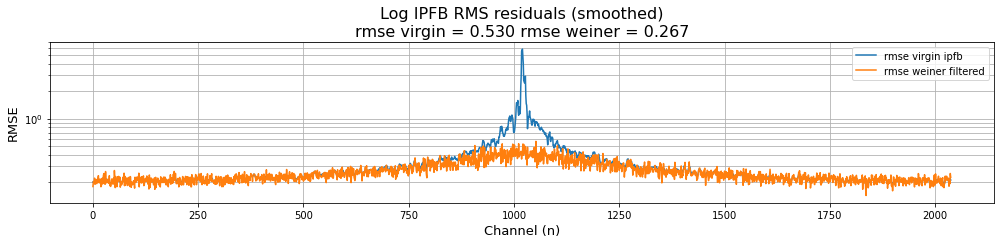

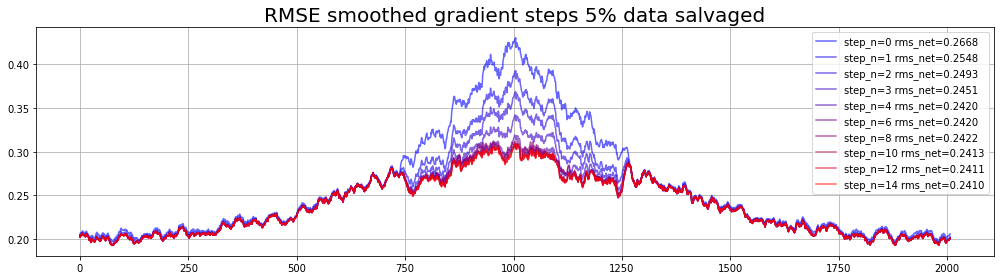

INFO: Conjugate Gradient descent completed.


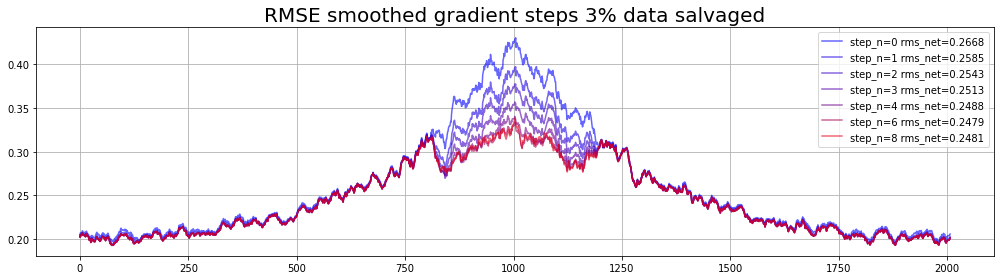

INFO: Conjugate Gradient descent completed.


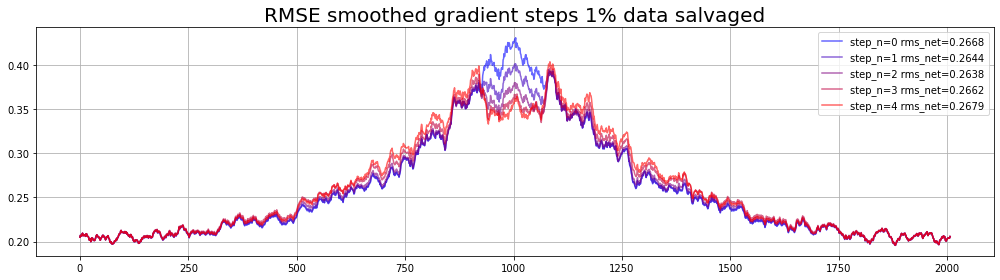

INFO: Conjugate Gradient descent completed.


In [50]:
simulate_quantization_error()